# Model Calibration

## Preliminary concepts

> A **bin** is a single range of continuous values used to group values of a continuous variable. Binning data helps simplify data visualizations.

![](https://cdn.serc.carleton.edu/images/mathyouneed/geomajors/histograms/histogram_bin_size_comparison_650.webp)

## What is Model Calibration?

> Model calibration is a procedure to **adjust** the output probabilities of a **binary classifier** so that they better reflect the true probabilities of the predicted outcomes. 

## Steps for Applying Model Calibration

Applying **model calibration** involves a structured set of steps to evaluate and improve how a model’s predicted probabilities reflect true likelihoods.

### Step 1. Split the Data

> First of all, **split the available data**.
  - **Training set** – used to train the base model.
  - **Calibration set** – held-out validation data **not used** in training, reserved for fitting the calibration method.
  - **Test Set** (optional but recommended) – to evaluate the final performance

---

### Step 2. Train the Base Model

> Train a probabilistic classifier (e.g., logistic regression, random forest, neural network) using the training set. Ensure that the model outputs **probability estimates**, not just class labels.

---

### Step 3: Fit a Calibration Model

> Using the calibration set, fit a model (using some **calibration method**, e.g., Platt Scaling, Isotonic Regression, Temperature Scaling) that transforms the uncalibrated outputs (scores or logits) of the base model into well-calibrated probabilities. The method used to fit this model should be appropriate to the characteristics of the data and the predictive distribution of the base model.
  - For Platt Scaling: Fit a logistic regression using model scores.
  - For Isotonic Regression: Fit a piecewise constant function.
  - For Temperature Scaling: Optimize temperature to minimize NLL (Negative Log-Likelihood).

### Step 4. Evaluate Calibration of the Base Model

> On test set, use a combination of calibration metrics (ECE, Brier Score, NLL) and discrimination metrics (AUROC, accuracy, etc.), in order to assess both probabilistic correctness and decision-making performance.

- 📉 **Reliability diagram**: Visual comparison between predicted probabilities and actual frequencies.
- 📊 **Expected Calibration Error (ECE)** or **Maximum Calibration Error (MCE)**: Numeric summaries of miscalibration.
- 🧮 **Brier Score**: Measures the mean squared difference between predicted probabilities and true outcomes.

### Step 5. Use Calibrated Model in Deployment
> Replace the raw model outputs with calibrated probabilities for any downstream application (e.g., threshold-based decisions, expected utility maximization, risk estimates).



# Calibration curves

A **calibration curve** (aka **reliability curve**, **calibration plot**) is a graphical representation that illustrates the relationship between predicted probabilities or scores generated by a classification model and the actual observed outcomes. It helps to assess how well-calibrated the predicted probabilities are with respect to the true probabilities of the outcomes.

Calibration curves are used in Step 4: Evaluation of the Calibrated Model — and, optionally, in Step 2 during initial diagnostics of the base model.

To build a calibration curve, we need predictions from a model on a given dataset. These predictions will serve as the basis for assessing the calibration of the model. Then, the usual steps to build a calibration curve are the following:

1. **Define the bins**. Divide the predicted values into [bins](https://en.wikipedia.org/wiki/Data_binning) or groups. This is done based on the predicted probabilities or scores generated by the model. Typically, the predictions are divided into equally spaced bins.

2. **Calculate the Mean Predicted Value and Observed Frequency in Each Bin**. For each bin, calculate the mean predicted value and the observed frequency of the corresponding true labels. This involves counting how many true labels fall into each bin.

3. **Plot the Calibration Curve**. Plot the mean predicted value (x-axis) against the observed frequency (y-axis) for each bin.

To understand the above steps, consider a toy example of 10 data points (instances) that were passed through a binary classifier. The table below presents the predicted probibility and the true label for each instance.

| Instance | Predicted Probability | True Label |
|----------|------------------------|------------|
1 | 0.10 | 0
2 | 0.15 | 0
3 | 0.30 | 1
4 | 0.35 | 1
5 | 0.55 | 1
6 | 0.60 | 1
7 | 0.70 | 0
8 | 0.85 | 1
9 | 0.90 | 1
10 | 0.95 | 1

### Step 1: Define the bins

Let's use **5 bins** of width 0.2:  
- $B_1$: [0.0, 0.2)  
- $B_2$: [0.2, 0.4)  
- $B_3$: [0.4, 0.6)  
- $B_4$: [0.6, 0.8)  
- $B_5$: [0.8, 1.0]

(Note that there are several alternative approaches to define bins.)

### Step 2: Calculate the Mean Predicted Value and Empirical Accuracy in Each Bin

> The **Mean Predicted Value** is the average of the prediction probabilities in the bin. That is the **model confidence** for that bin.
$$
\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} p_i
$$

> The **Empirical Accuracy** (also called observed frequency or positive rate) is the proportion of true labels in the bin. That is, it is the observed frequency of the positive class in the bin.
$$
\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} y_i
$$


For the toy dataset, we have:

| Bin     | Predictions in Bin | Mean Predicted Value | Empirical Accuracy |
|---------|--------------------|---------------------|-------------------|
| $B_1$   | 0.10, 0.15         | 0.125               | 0/2 = 0.00        |
| $B_2$   | 0.30, 0.35         | 0.325               | 1/2 = 0.50        |
| $B_3$   | 0.55, 0.60         | 0.575               | 2/2 = 1.00        |
| $B_4$   | 0.70               | 0.70                | 0/1 = 0.00        |
| $B_5$   | 0.85, 0.90, 0.95   | 0.90                | 3/3 = 1.00        |

### Step 3: Plot the Calibration Curve

Plot the following pairs on a chart:
- (0.125, 0.00)
- (0.325, 0.50)
- (0.575, 1.00)
- (0.70,  0.00)
- (0.90,  1.00)

Also plot the **diagonal line** $y = x$ representing perfect calibration, to serve as a baseline for comparison.

---
Let us use Python to implement the steps above.

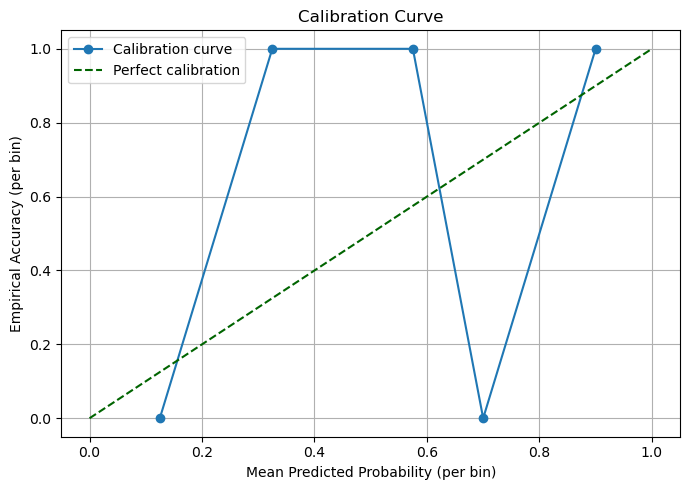

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated data
y_prob = np.array([0.10, 0.15, 0.30, 0.35, 0.55, 0.60, 0.70, 0.85, 0.90, 0.95])
y_true =    np.array([0,    0,    1,    1,    1,    1,    0,    1,    1,    1])

# Step 1. Bin assignment
bin_edges = np.linspace(0.0, 1.0, 6)
bin_ids = np.digitize(y_prob, bin_edges, right=False) - 1

# Step 2. Construct bin-wise summary
bin_data = pd.DataFrame({'bin': bin_ids, 'prob': y_prob, 'label': y_true})
calibration_summary = bin_data.groupby('bin').agg(
    mean_predicted_prob=('prob', 'mean'),
    empirical_accuracy=('label', 'mean'),
    count=('label', 'size')
).reset_index()

# Step 3. Plot calibration curve
plt.figure(figsize=(7, 5))
plt.plot(calibration_summary['mean_predicted_prob'],
         calibration_summary['empirical_accuracy'],
         marker='o', linestyle='-', label='Calibration curve')

plt.plot([0, 1], [0, 1], linestyle='--', color='darkgreen', label='Perfect calibration')

plt.xlabel('Mean Predicted Probability (per bin)')
plt.ylabel('Empirical Accuracy (per bin)')
plt.title('Calibration Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

We can also display the calibration summary in tabular form.

In [83]:
calibration_summary.head()

,bin,mean_predicted_prob,empirical_accuracy,count
0,0,0.125,0.0,2
1,1,0.325,1.0,2
2,2,0.575,1.0,2
3,3,0.700,0.0,1
4,4,0.900,1.0,3


## Interpretation of Calibration Curves

- Overconfidence means that the model **believes** the positive class is more likely than it actually is, **on average** in that bin. A model is **overconfident** in a bin $B_m$ when:

$$
\boxed{\text{conf}(B_m) > \text{acc}(B_m)}
$$

- Underconfidence means that the model **believes** the positive class is less likely than it actually is, **on average** in that bin. A model is **overconfident** in a bin $B_m$ when:
$$
\boxed{\text{conf}(B_m) < \text{acc}(B_m)}
$$

- Only a bin where both quantities are approximately equal would be called well-calibrated.


> A well-calibrated model is neither overconfident nor underconfident in each bin. For a well-calibrated model, its calibration curve shows points lying close to the diagonal line (the line of perfect calibration).


Let us see an example in the context of $B_1$. This bin was defined as: $B_1$: $[0.0, 0.2)$. Within this bin, we included:

| Instance | Predicted Probability | True Label |
|----------|------------------------|------------|
| 1        | 0.10                   | 0          |
| 2        | 0.15                   | 0          |

So both predictions in this bin had true labels = 0. So,

$$
\text{acc}(B_1) = \frac{0}{2} = 0.0
$$

and

$$
\text{conf}(B_1) = \frac{0.10 + 0.15}{2} = 0.125
$$


> Model is overconfident in $B_1$  (**because the average predicted probability was greater than the observed frequency of positives**). Concretely, the model predicted that 12.5% of instances in $B_1$ to be positive, but 0% positives were observed.

The table below presents a summary for each bin. 

 Bin | Mean Predicted Probability (conf) | Empirical Accuracy (acc) | Count | Interpretation 
-----|----------------------------|--------------------|-------|----------------
1 | 0.125 | 0.00 | 2 | Overconfident 
2 | 0.325 | 1.00 | 2 | Underconfident 
3 | 0.575 | 1.00 | 2 | Underconfident 
4 | 0.70 | 0.00 | 1 | Overconfident 
5 | 0.90 | 1.00 | 3 | Slightly underconfident (mild) 

---

## CalibrationDisplay

The block of code below creates a helper function that plots a calibration curve. It is implemented leveraging the [sklearn.calibration.CalibrationDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html) class. 

In the resulting plot, each dot corresponds to a bin.
- The x-coordinate is the mean predicted probability for elements of the bin (one can also use
other approaches to get a probability prediction for the bin as a whole)
- The y-coordinate is the fraction of elements in the bin for which the event actually occurs

Notice that a perfectly calibrated model would correspond to the line y = x (black line).

In [84]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

def plot_calibration_curve(y_test, y_prob, plot_title="Calibration Curve", method_label="", n_bins=15):
    disp = CalibrationDisplay.from_predictions(y_test, 
                                            y_prob, 
                                            n_bins=n_bins,
                                            color='red',  # Color of the line
                                            marker='o',  # Marker style
                                            markersize=4,  # Size of the markers
                                            markeredgecolor='red',  # Edge color of the markers
                                            markerfacecolor='red', 
                                            label=method_label,  # Custom label
                                            )

    disp.ax_.set_title(plot_title)

    plt.grid(True)
    plt.show()

## calibration_curve

The [``calibration_curve``](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html) function computes calibration data by grouping predicted probabilities into bins, calculating the average true probabilities within each bin, and retaining only bins with a sufficient number of samples for analysis. The resulting data can be used to evaluate the calibration of a predictive model's probabilities.
____________________
Input Parameters:
- `y_true`: the true labels or outcomes of the data.
- `y_prob`: the predicted probabilities (for the positive class) generated by the model.

____________________
Output. The function returns two arrays:
- `prob_true`: The proportion of samples whose class is the positive class, in each bin (fraction of positives).
- `prob_pred`: The mean predicted probability in each bin.


The code below produces the calibration plot corresponding to the toy model, this time using `calibration_curve`.

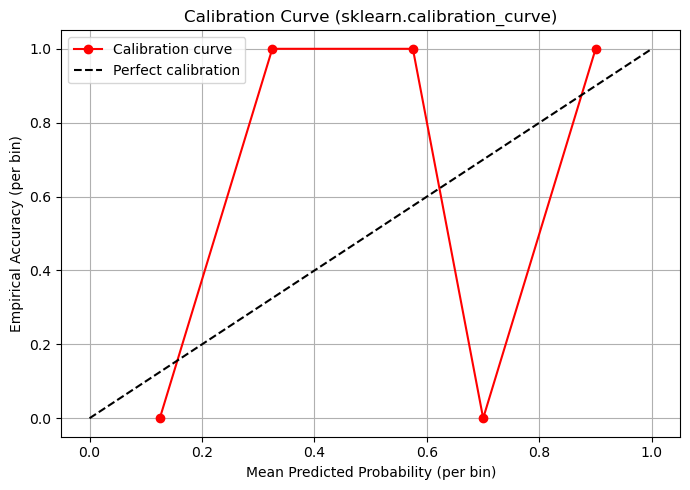

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Recreate data
y_true =    np.array([0,    0,    1,    1,    1,    1,    0,    1,    1,    1])  # changed one label
y_prob = np.array([0.10, 0.15, 0.30, 0.35, 0.55, 0.60, 0.70, 0.85, 0.90, 0.95])

# Use sklearn's calibration_curve
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=5, strategy='uniform')

# Plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration curve', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect calibration')

plt.xlabel('Mean Predicted Probability (per bin)')
plt.ylabel('Empirical Accuracy (per bin)')
plt.title('Calibration Curve (sklearn.calibration_curve)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The code below produces the calibration plot corresponding to the toy model, this time using the helper function `plot_calibration_curve`.

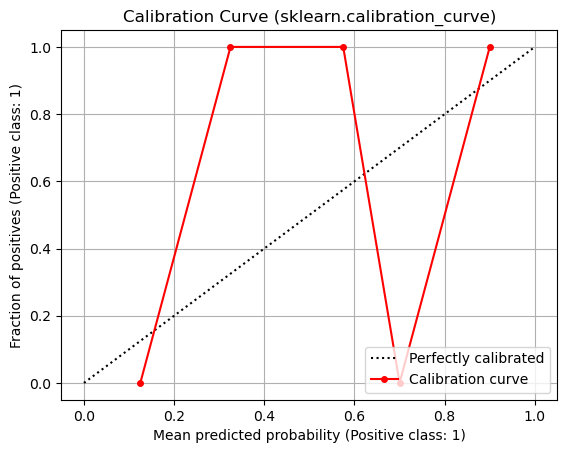

In [86]:
plot_calibration_curve(y_test=y_true, 
                       y_prob=y_prob, 
                       plot_title="Calibration Curve (sklearn.calibration_curve)", 
                       method_label="Calibration curve", 
                       n_bins=5)

# (Step 3) Fitting a calibration model

## CalibratedClassifierCV

Scikit-Learn provides the class [CalibratedClassifierCV](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html), which is meant to calibrate a model on a particular X, y dataset. It should be noted that datasets for fitting the base classifier (Step 2) and for calibrating it (Step 3) must be disjoint.

### Approach 1
In this approach, we train base model outside CCCV and then use CCCV to train one calibration model on DISJOINT set.

Steps:
  1. Get the two disjoint datasets: ``(X_train, y_train)``, and ``(X_calib, y_calib)``. The former is used to train the base model. The later is used to calibrate it.
  2. Train the base model: ``model.fit(X_train, y_train)``.
  3. Create an instance of CCCV: ``cccv = CalibratedClassifierCV(model, cv='prefit')``. Notice ``cv`` is used to flag that ``model`` has already been fit. 
  4. Perform the calibration: ``cccv.fit(X_calib, y_calib)``. In this case, no cross-validation is performed and all provided data is used for calibration.

Pseudocode:
```
model.fit(X_train, y_train)
cccv = CalibratedClassifierCV(model, cv='prefit')
cccv.fit(X_val, y_val)
```

### Approach 2
In this approach, the `CalibratedClassifierCV` object would fit a given estimator `cv` times, and the probabilities for each of the folds are then averaged for prediction. Also, the base model is fitted CCCV.

Steps:
  1. Start with a new, untrained model.
  2. Create an instance of CCCV: ``cccv = CalibratedClassifierCV(model, cv=5)``. Notice ``cv`` is now the number of folds.
  3. Perform the calibration: ``cccv.fit(X, y)``. Because ``model`` is untrained, ``X`` and ``y`` have to be used for both training and calibration. The way to ensure the data is **disjoint** is cross validation: for any given fold, CCCV will split ``X`` and ``y`` into training and calibration data, so they do not overlap.

Pseudocode:
```
cccv = CalibratedClassifierCV(model, cv=5   )
cccv.fit(X, y)
```

## Example

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Custom ordinal mapping for Education
education_order = [
    ' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th',
    ' 10th', ' 11th', ' 12th', ' HS-grad',
    ' Some-college', ' Assoc-voc', ' Assoc-acdm',
    ' Bachelors', ' Masters', ' Prof-school', ' Doctorate'
]
education_mapping = {level: idx for idx, level in enumerate(education_order)}

# Load data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# Filter for United States and select columns
df = df[df.NativeCountry == ' United-States']
df = df[["Education", "Age", "Occupation", "HoursPerWeek", "Income"]]

# Apply ordinal encoding to Education
df["Education"] = df["Education"].map(education_mapping)

# Label encode nominal features
def label_encoder(df, columns):
    le_dict = {}
    for c in columns:
        print(f"Label encoding column - {c}")
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c])
        le_dict[c] = le
    return df, le_dict

df, _ = label_encoder(df, columns=["Occupation", "Income"])

# Prepare features and target
X = df[["Education", "Age", "Occupation", "HoursPerWeek"]]
y = df["Income"]

# Split dataset
seed = 42
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
X_train, X_calib, y_train, y_calib = train_test_split(X_temp, y_temp, test_size=0.40, random_state=seed, stratify=y_temp)
# Check the distribution of the target variable in the training set
print("Training set distribution:")
print(y_train.value_counts(normalize=True))
# Check the distribution of the target variable in the calibration set
print("Calibration set distribution:")
print(y_calib.value_counts(normalize=True))
# Check the distribution of the target variable in the test set
print("Test set distribution:")
print(y_test.value_counts(normalize=True))
# Check the distribution of the target variable in the entire dataset
print("Entire dataset distribution:")
print(df["Income"].value_counts(normalize=True))

Label encoding column - Occupation
Label encoding column - Income
Training set distribution:
Income
0    0.754143
1    0.245857
Name: proportion, dtype: float64
Calibration set distribution:
Income
0    0.754163
1    0.245837
Name: proportion, dtype: float64
Test set distribution:
Income
0    0.7542
1    0.2458
Name: proportion, dtype: float64
Entire dataset distribution:
Income
0    0.754165
1    0.245835
Name: proportion, dtype: float64


Now we fit the base model and plot its corresponding calibration curve.

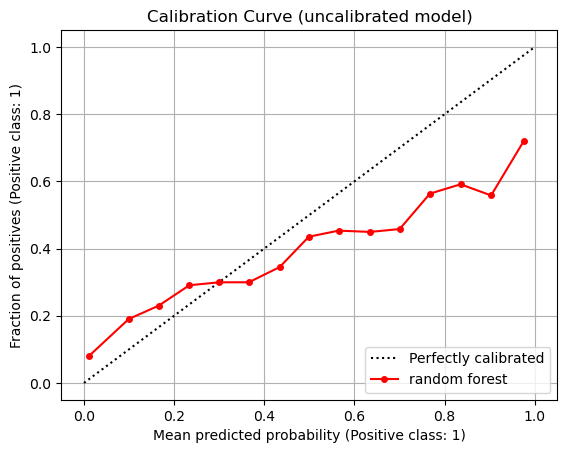

In [88]:
from sklearn.ensemble import RandomForestClassifier

# Fitting the base model on training data
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

y_prob = rf_model.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test=y_test, y_prob=y_prob, plot_title="Calibration Curve (uncalibrated model)", method_label="random forest")

## Calibration methods

A calibration method works by using the original model’s uncalibrated predictions as input for training a second model that maps the uncalibrated scores to calibrated probabilities. To prevent bias, it is important to use a new set of observations to fit the second model.

> Notice that a calibration method solves a probabilistic binary classification problem with a single input feature (which is the probability produced by the original model), and the target is the same as in the original model.


### Method 1: Isotonic Regression

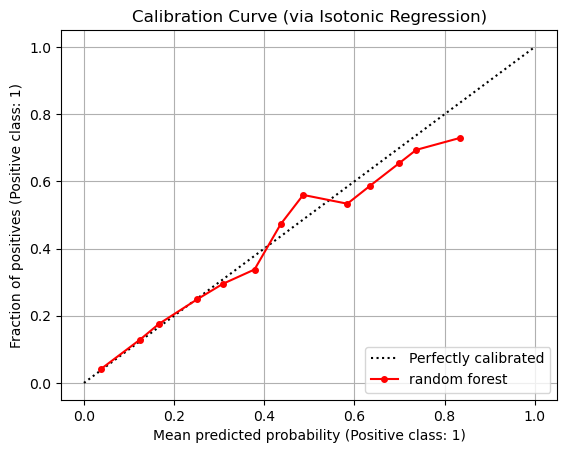

In [89]:
from sklearn.calibration import CalibratedClassifierCV

# Train base model using random forest. Then uses isotonic regression for calibration.
# We use CCCV as described in the first approach above.
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
calibrated_rf = CalibratedClassifierCV(rf, cv = 'prefit', method = 'isotonic')
calibrated_rf.fit(X_calib, y_calib)
y_prob = calibrated_rf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test=y_test, y_prob=y_prob, plot_title="Calibration Curve (via Isotonic Regression)", method_label="random forest")

### Method 2: Sigmoid / Platt scaling

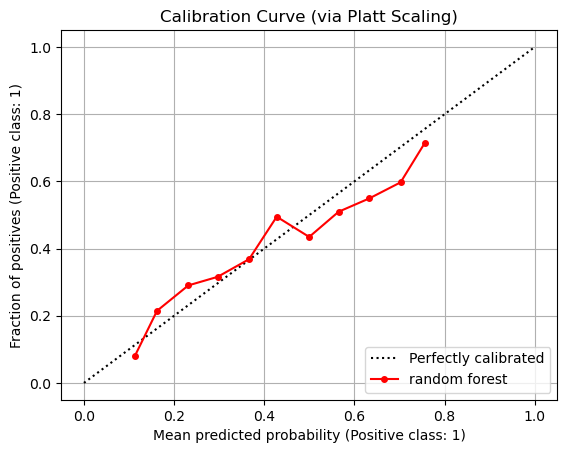

In [90]:
# Train base model using random forest. Then uses sigmoid method for calibration.
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
calibrated_sigmoid = CalibratedClassifierCV(rf, cv = 'prefit', method = 'sigmoid')
calibrated_sigmoid.fit(X_calib, y_calib)
y_prob = calibrated_sigmoid.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test=y_test, y_prob=y_prob, plot_title="Calibration Curve (via Platt Scaling)", method_label="random forest")

### Method 3: Train with “Logloss” metric

Models generated with the `GradientBoostingClassifier` already provide pretty good probability estimates from the start, since the loss function used in this algorithm is optimized for probability estimation.

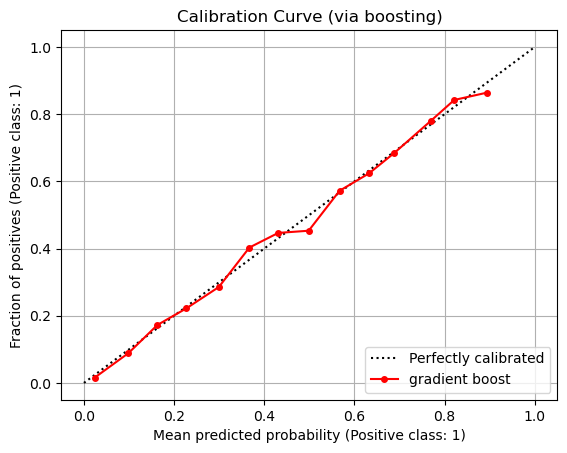

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

## Fitting the model on training data
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_prob = gb_model.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test=y_test, y_prob=y_prob, plot_title="Calibration Curve (via boosting)", method_label="gradient boost")

# (Step 4) Evaluate Calibration of the Base Model

The purpose of Step 4 is to assess how well the **calibrated model** performs on unseen data. Hence, the evaluation is conducted on a **held-out test set** that was **not used** during either training or calibration. Concretely, we are trying to answer the following question:

> After model calibration, are the predicted probabilities statistically aligned with reality?

## 🧪 Calibration Metrics

### 1. **Expected Calibration Error (ECE)**

$$
\text{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{n} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
$$

- $B_m$: bin of predicted probabilities  
- $\text{acc}(B_m)$: empirical accuracy in the bin  
- $\text{conf}(B_m)$: average predicted probability in the bin  
- Lower ECE → better calibration.

✅ **Interpretation**: Measures the average absolute difference between predicted confidence and observed accuracy.

---

### 2. **Brier Score**

$$
\text{BS} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{p}(x_i) - y_i \right)^2
$$

- A strictly proper scoring rule.
- Can be decomposed into:
  - **Reliability** (calibration)
  - **Resolution**
  - **Uncertainty**

✅ **Interpretation**: A lower Brier score indicates better probabilistic accuracy.

---

### 3. **Negative Log-Likelihood (Log Loss)**

$$
\text{NLL} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{p}(x_i)) + (1 - y_i) \log(1 - \hat{p}(x_i)) \right]
$$

- Penalizes overconfident wrong predictions heavily.
- Strictly proper: minimized only when $\hat{p}(x_i) = \mathbb{P}(Y = 1 \mid x_i)$

✅ **Interpretation**: Measures how "surprised" the model is by the actual outcomes.

### 🧾 Summary Table

| Metric         | Type            | Purpose                     | Notes                             |
|----------------|-----------------|-----------------------------|-----------------------------------|
| **ECE**        | Calibration     | Confidence vs. reality      | Should be as low as possible      |
| **Brier Score**| Calibration     | Probabilistic MSE           | Lower is better                   |
| **Log Loss**   | Calibration     | Probabilistic cross-entropy | Strictly proper scoring rule      |

## Example

The code below shows a full working example that computes ECE values before and after calibration.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# Function to manually compute ECE
def compute_ece(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bin_edges, right=True) - 1

    ece = 0.0
    for i in range(n_bins):
        bin_mask = (bin_ids == i)
        if np.any(bin_mask):
            bin_confidence = np.mean(y_prob[bin_mask])
            bin_accuracy = np.mean(y_true[bin_mask])
            bin_size = np.sum(bin_mask)
            ece += (bin_size / len(y_true)) * np.abs(bin_accuracy - bin_confidence)
    return ece

# Generate synthetic dataset
X, y = make_classification(n_samples=3000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

# Correct split: Train / Calibration / Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train base model
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

# Predict probabilities (base model)
y_prob_base = base_model.predict_proba(X_test)[:, 1]

# Apply Platt scaling (sigmoid) using separate calibration set
calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_calib, y_calib)
y_prob_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Compute manual ECE
ece_base = compute_ece(y_test, y_prob_base, n_bins=10)
ece_calibrated = compute_ece(y_test, y_prob_calibrated, n_bins=10)

print(f"ECE (base model): {ece_base:.4f}")
print(f"ECE (calibrated model): {ece_calibrated:.4f}")

ECE (base model): 0.1456
ECE (calibrated model): 0.0315


The code below plot the reliability diagrams (before vs after calibration) so we can visually see the improvement.

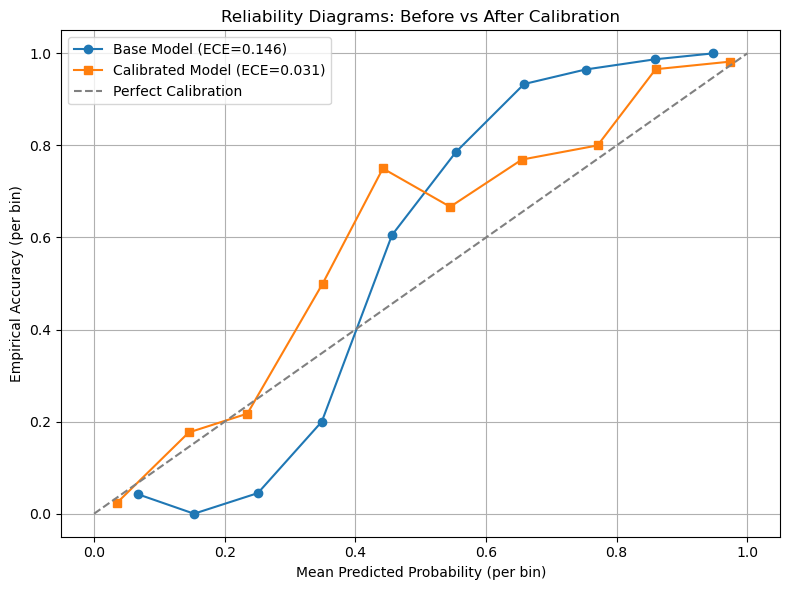

In [93]:
from sklearn.calibration import calibration_curve

# Generate calibration curves
prob_true_base, prob_pred_base = calibration_curve(y_test, y_prob_base, n_bins=10, strategy='uniform')
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, y_prob_calibrated, n_bins=10, strategy='uniform')

# Plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_base, prob_true_base, marker='o', label=f'Base Model (ECE={ece_base:.3f})')
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='s', label=f'Calibrated Model (ECE={ece_calibrated:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability (per bin)')
plt.ylabel('Empirical Accuracy (per bin)')
plt.title('Reliability Diagrams: Before vs After Calibration')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Final Remarks

## When to Consider Applying Model Calibration

Model calibration should be considered whenever the predicted probabilities from a machine learning model are intended to be interpreted as reliable estimates of the true probabilities of the outcomes. Here are some scenarios in which applying model calibration is particularly important:

- Probabilistic Predictive Models: If the predictive model outputs probabilities, especially in classification tasks, calibration becomes crucial. Models like logistic regression, support vector machines with probabilistic outputs, and probabilistic graphical models often require calibration.

- Decision Making Under Uncertainty: When decisions are made based on predicted probabilities, such as in risk assessment, medical diagnosis, or financial forecasting, it's essential that these probabilities are well-calibrated to reflect the true likelihood of the outcomes.

- Fairness and Bias Mitigation: In applications where fairness and bias mitigation are critical, calibrated probabilities can help ensure equitable treatment across different groups or demographics.

- Reliability and Trustworthiness: Calibrated probabilities contribute to the overall reliability and trustworthiness of the predictive model. Users and stakeholders are more likely to trust a model that provides accurate probability estimates.

- Performance Improvement: Well-calibrated models often lead to better performance in downstream tasks such as classification accuracy, precision-recall curves, or area under the ROC curve (AUC).

- Model Interpretability: Calibrated probabilities can also aid in model interpretability by providing more meaningful and reliable insights into the model's behavior.

- Legal and Regulatory Compliance: In some domains, such as finance, healthcare, and criminal justice, regulatory requirements may mandate the use of calibrated probabilities to ensure compliance with legal standards and ethical guidelines.

It's worth noting that not all machine learning models require calibration. In situations where the model outputs probabilities, especially when those probabilities are used for decision-making or risk assessment, model calibration is an important consideration to ensure the reliability and usefulness of the model's predictions.

## When to Use Each Calibration Method

| Method                  | Description                               | When to Use                         |
|-------------------------|-------------------------------------------|-------------------------------------|
| **Platt Scaling**       | Fits a logistic regression on scores      | Simple models, sigmoid-shaped probs |
| **Isotonic Regression** | Non-parametric, monotonic fit             | More flexible, needs more data      |
| **Temperature Scaling** | Single temperature parameter for logits   | Common for neural networks          |



# References

## Papers

1. Alexandru Niculescu-Mizil and Rich Caruana (2005): [Predicting Good Probabilities With Supervised Learning](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf), in Proceedings of the 22nd International Conference on Machine Learning (ICML).
2. [Obtaining calibrated probability estimates from decision trees and naive Bayesian classifiers](https://cseweb.ucsd.edu/~elkan/calibrated.pdf)

## Posts
1. [Model calibration for classification tasks using Python](https://medium.com/data-science-at-microsoft/model-calibration-for-classification-tasks-using-python-1a7093b57a46), by Aayush Agrawal.
2. [Can I trust my model’s probabilities? A deep dive into probability calibration](https://ploomber.io/blog/calibration-curve/), by Eduardo Blancas (ploomber.io).
3. [Understanding sklearn.CalibratedClassifierCV](https://stackoverflow.com/questions/70211643/understanding-sklearn-calibratedclassifiercv)
4. [Why does CalibratedClassifierCV underperform a direct classifer?](https://stackoverflow.com/questions/30285551/why-does-calibratedclassifiercv-underperform-a-direct-classifer?rq=3)
5. [How and When to Use a Calibrated Classification Model with scikit-learn](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)
6. [Probability Calibration curves](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py), from scikit-learn docs.
7. [A Comprehensive Guide on Model Calibration: What, When, and How](https://towardsdatascience.com/a-comprehensive-guide-on-model-calibration-part-1-of-4-73466eb5e09a)

## Videos
1. [Model Calibration | Machine Learning](https://youtu.be/hWb-MIXKe-s) (~5min video explaining the essence of model calibration)
2. [Calibration in Machine learning Models - Predicting Good Probabilities With Supervised Learning](https://youtu.be/10xNxvXiIT0)
3. [Probability Calibration Workshop - Introduction](https://youtu.be/A1NGGV3Z4m4?list=PLeVfk5xTWHYBw22D52etymvcpxey4QFIk), by Brian Lucena (Numeristical)
4. [Applied ML 2020 - 10 - Calibration, Imbalanced data](https://youtu.be/w3OPq0V8fr8)
5. [CS8850 AML - On Model Calibration](https://youtu.be/rRhKGNFyPhg?list=PLWL87aJW5Y--YMBUgw4yn28_njbLMHINR)